<script>
    function toggleCode() {
        var codeCells = document.getElementsByClassName('code_cell');
        for (var i = 0; i < codeCells.length; i++) {
            codeCells[i].getElementsByClassName('input')[0].style.display = 'none';
        }
    }
    toggleCode();
</script>

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from ipywidgets import interact, widgets, FloatSlider, Play, VBox
from IPython.display import display, Javascript, HTML

#-----------------------------------------------------------
# Define a JavaScript function to scroll to the top of the next cell
scroll_to_next_cell = """
<script>
    function scrollToNextCell() {
        var currentCell = Jupyter.notebook.get_selected_cell();
        var currentCellIndex = Jupyter.notebook.find_cell_index(currentCell);
        var nextCell = Jupyter.notebook.get_cell(currentCellIndex + 1);
        if (nextCell) {
            nextCell.element[0].scrollIntoView({behavior: 'smooth', block: 'start'});
        }
    }
</script>
"""
# Execute the JavaScript function after running the cell
Javascript(scroll_to_next_cell)

#-----------------------------------------------------------
# Set the current directory to the notebook directory
dir = os.path.dirname(os.path.abspath("__file__"))

# Read in excel file as a data frame
mpmsdc_dfs = pd.read_excel(os.path.join(dir, "rock_magnetic_bestiary_mpms.xlsx"), sheet_name=None, header=None)
mpmsdc = pd.concat(mpmsdc_dfs, ignore_index=True) 
mpmsdc = mpmsdc.astype(str)

for column in mpmsdc.columns:
    mpmsdc[column] = mpmsdc[column].str.replace("RT remanence on cooling", "RT remanence cooling")

#-------------------------------------------------------------------------------------------------------     
# Define global variables

selected_measurement = None
selected_measurement_name1 = None
selected_measurement_name2 = None
selected_specimen1 = None
selected_specimen2 = None
sp1_data = None
sp1_data1 = None
sp1_data2 = None
sp2_data = None
sp2_data1 = None
sp2_data2 = None
x1 = None
y1 = None
x2 = None
y2 = None
x1_1 = None
y1_1 = None
x1_2 = None
y1_2 = None
x2_1 = None
y2_1 = None
x2_2 = None
y2_2 = None

doubles = ["FC, remanence","ZFC, remanence","RT remanence on cooling","RT remanence cooling", "RT remanence warming"]

#-------------------------------------------------------------------------------------------------------
# Make a list of specimen names
names = mpmsdc.loc[0].dropna().unique()

# Store default specimen and measurement
initial_measurements = mpmsdc.loc[1][mpmsdc.loc[0] == names[0]].dropna().unique()
default_measurement = initial_measurements[0]

# Define a function to run the next cell when the dropdowns are changed
def run_next_cell(change):
    display(Javascript('''
        try {
            Jupyter.notebook.execute_cells([Jupyter.notebook.get_selected_index() + 1]);
        } catch(err) {
            console.error('Error executing next cell:', err);
        }
    '''))
    
#-------------------------------------------------------------------------------------------------------
# Define a function to update the selected specimen and set it as a variable
def update_specimen1(change):
    global selected_specimen1
    global initial_measurements
    
    sp1_data = None
    sp1_data1 = None
    sp1_data2 = None
    sp2_data = None
    sp2_data1 = None
    sp2_data2 = None
    
    selected_specimen1 = change.new
    
    # Update the options of the measurements dropdown based on the selected specimen
    initial_measurements = mpmsdc.loc[1][mpmsdc.loc[0] == selected_specimen1].dropna().unique()
    measurements.options = initial_measurements
    
     # Extract data associated with the first specimen name and the selected measurement type
    if selected_measurement in ["FC, remanence", "ZFC, remanence"]:
        selected_measurement_name1 = "FC, remanence"
        selected_measurement_name2 = "ZFC, remanence"
        sp1_data1 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name1)].iloc[5:, [0, 2]]
        sp1_data2 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name2)].iloc[5:, [0, 2]]
    elif selected_measurement in ["RT remanence cooling", "RT remanence warming"]:
        selected_measurement_name1 = "RT remanence cooling"
        selected_measurement_name2 = "RT remanence warming"        
        sp1_data1 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name1)].iloc[5:, [0, 2]]
        sp1_data2 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name2)].iloc[5:, [0, 2]]    
    else:
        sp1_data = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement)].iloc[5:, [0, 2]]
    
    # Convert data to numeric (assuming columns 1 and 3 are numeric)
    if selected_measurement not in doubles:
        sp1_data = sp1_data.apply(pd.to_numeric, errors='coerce')
    
    # Convert data1 and data2 to numeric (assuming columns 1 and 3 are numeric)
    if selected_measurement in doubles:
        sp1_data1 = sp1_data1.apply(pd.to_numeric, errors='coerce')
        sp1_data2 = sp1_data2.apply(pd.to_numeric, errors='coerce')
    
    # Remove rows with NaN values in either column 1 or column 3
    if selected_measurement in doubles:
        sp1_data1 = sp1_data1.dropna()
        sp1_data2 = sp1_data2.dropna()
    else:
        sp1_data = sp1_data.dropna()

#-------------------------------------------------------------------------------------------------------      
# Define a function to update the selected measurement and set it as a variable
def update_measurement(change):
    global selected_measurement
    global selected_measurement_name1
    global selected_measurement_name2
    global selected_specimen1
    global selected_specimen2
    global sp1_data
    global sp1_data1
    global sp1_data2
    global doubles
    
    # Initialize variables
    sp1_data = None
    sp1_data1 = None
    sp1_data2 = None
    
    # Update selected measurement
    selected_measurement = change.new
    
    # Extract data associated with the first specimen name and the selected measurement type
    if selected_measurement in ["FC, remanence", "ZFC, remanence"]:
        selected_measurement_name1 = "FC, remanence"
        selected_measurement_name2 = "ZFC, remanence"
        sp1_data1 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name1)].iloc[5:, [0, 2]]
        sp1_data2 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name2)].iloc[5:, [0, 2]]
    elif selected_measurement in ["RT remanence cooling", "RT remanence warming"]:
        selected_measurement_name1 = "RT remanence cooling"
        selected_measurement_name2 = "RT remanence warming"        
        sp1_data1 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name1)].iloc[5:, [0, 2]]
        sp1_data2 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement_name2)].iloc[5:, [0, 2]]    
    else:
        sp1_data = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen1) & (mpmsdc.iloc[1] == selected_measurement)].iloc[5:, [0, 2]]
    
    # Convert data to numeric (assuming columns 1 and 3 are numeric)
    if selected_measurement not in doubles:
        sp1_data = sp1_data.apply(pd.to_numeric, errors='coerce')
    
    # Convert data1 and data2 to numeric (assuming columns 1 and 3 are numeric)
    if selected_measurement in doubles:
        sp1_data1 = sp1_data1.apply(pd.to_numeric, errors='coerce')
        sp1_data2 = sp1_data2.apply(pd.to_numeric, errors='coerce')
    
    # Remove rows with NaN values in either column 1 or column 3
    if selected_measurement in doubles:
        sp1_data1 = sp1_data1.dropna()
        sp1_data2 = sp1_data2.dropna()
    else:
        sp1_data = sp1_data.dropna()
    
    # Update options for Specimen 2 dropdown based on the selected measurement type
    initial_specimens = mpmsdc.loc[0][mpmsdc.loc[1] == selected_measurement].dropna().unique()
    specimen2_dropdown.options = initial_specimens

#-------------------------------------------------------------------------------------------------------
# Define a function to update selected specimen2 and set it as a variable
def update_specimen2(change):
    global selected_measurement
    global selected_measurement_name1
    global selected_measurement_name2
    global selected_specimen1
    global selected_specimen2
    global sp2_data
    global sp2_data1
    global sp2_data2
    global doubles
    
    # Initialize variables
    sp2_data = None
    sp2_data1 = None
    sp2_data2 = None
    
    selected_specimen2 = change.new
    
    # Extract data associated with the 2nd specimen name and the selected measurement type
    if selected_measurement in ["FC, remanence", "ZFC, remanence"]:
        selected_measurement_name1 = "FC, remanence"
        selected_measurement_name2 = "ZFC, remanence"
        sp2_data1 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen2) & (mpmsdc.iloc[1] == selected_measurement_name1)].iloc[5:, [0, 2]]
        sp2_data2 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen2) & (mpmsdc.iloc[1] == selected_measurement_name2)].iloc[5:, [0, 2]]
    elif selected_measurement in ["RT remanence cooling", "RT remanence warming"]:
        selected_measurement_name1 = "RT remanence cooling"
        selected_measurement_name2 = "RT remanence warming"        
        sp2_data1 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen2) & (mpmsdc.iloc[1] == selected_measurement_name1)].iloc[5:, [0, 2]]
        sp2_data2 = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen2) & (mpmsdc.iloc[1] == selected_measurement_name2)].iloc[5:, [0, 2]]    
    else:
        sp2_data = mpmsdc.loc[:, (mpmsdc.iloc[0] == selected_specimen2) & (mpmsdc.iloc[1] == selected_measurement)].iloc[5:, [0, 2]]
    
    # Convert data to numeric (assuming columns 1 and 3 are numeric)
    if selected_measurement not in doubles:
        sp2_data = sp2_data.apply(pd.to_numeric, errors='coerce')
    
    # Convert data1 and data2 to numeric (assuming columns 1 and 3 are numeric)
    if selected_measurement in doubles:
        sp2_data1 = sp2_data1.apply(pd.to_numeric, errors='coerce')
        sp2_data2 = sp2_data2.apply(pd.to_numeric, errors='coerce')
    
    # Remove rows with NaN values in either column 1 or column 3
    if selected_measurement in doubles:
        sp2_data1 = sp2_data1.dropna()
        sp2_data2 = sp2_data2.dropna()
    else:
        sp2_data = sp2_data.dropna()
        
#-------------------------------------------------------------------------------------------------------
    
# Create a dropdown menu for selecting specimen
specimen1_dropdown = widgets.Dropdown(options=names, description="Select Specimen 1", style={'description_width': 'initial'})

# Display the specimen1 dropdown
#display(specimen1_dropdown)

# Add an observer to capture the selected value and call the update_specimen function
specimen1_dropdown.observe(update_specimen1, names='value')
#specimen1_dropdown.observe(update_measurement, names='value')
specimen1_dropdown.observe(run_next_cell, names='value')  

# Initialize measurement dropdown with options based on the first specimen
measurements = widgets.Dropdown(options=initial_measurements, value=default_measurement, description="Select Measurement", style={'description_width': 'initial'})
#display(measurements)

# Add an observer to capture the selected value and call the update_measurement function
measurements.observe(update_measurement, names='value')
measurements.observe(run_next_cell, names='value')  

# Initialize specimen2 dropdown with options based on the default measurement
initial_specimens = mpmsdc.loc[0][mpmsdc.loc[1] == default_measurement].dropna().unique()
specimen2_dropdown = widgets.Dropdown(options=initial_specimens, description="Select Specimen 2", style={'description_width': 'initial'})

# Display the specimen2 dropdown
#display(specimen2_dropdown)

# Add an observer to capture the selected value and call the update_specimen2 function
specimen2_dropdown.observe(update_specimen2, names='value')
specimen2_dropdown.observe(run_next_cell, names='value')

gui_box = widgets.VBox([specimen1_dropdown, measurements, specimen2_dropdown])
display(gui_box)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

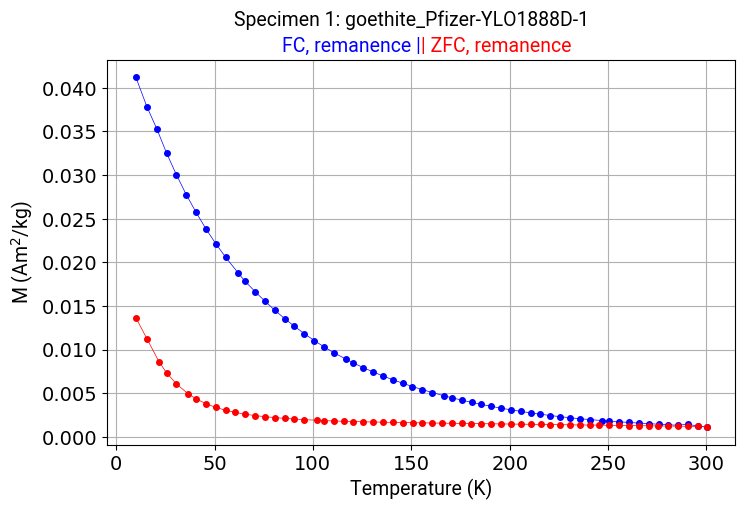

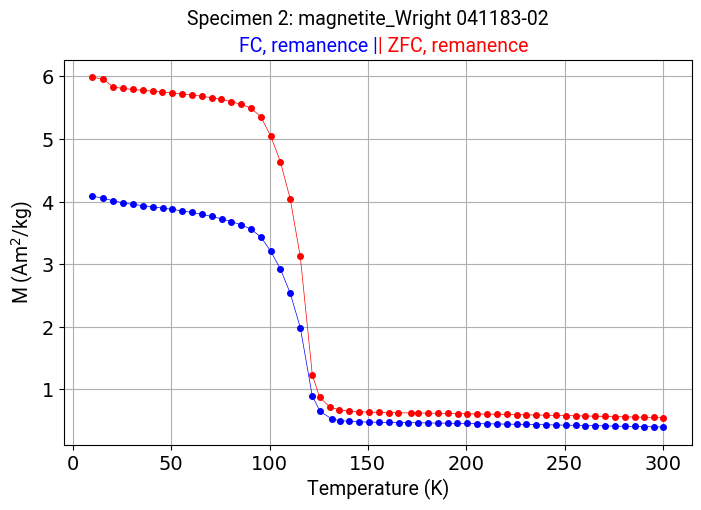

<Figure size 640x480 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='ratio', max=1.0, step=0.001), Output()), _dom_classe…

<function __main__.update_plot(ratio)>

In [22]:
# Define plot styling
ctype = {
    "FC, induced": ('LightSkyBlue', 'FC, induced'),
    "ZFC, induced moment": ('LightCoral', 'ZFC, induced moment'),
    "FC, remanence": ('Blue', 'FC, remanence'),
    "ZFC, remanence": ('Red', 'ZFC, remanence'),
    "RT remanence cooling": ('Black', 'RT remanence cooling'),
    "RT remanence warming": ('Green', 'RT remanence warming'),
    "Js v. T": ('Orange', 'Js v. T')
}

# Define a function to get color from ctype
def get_color(measurement_type):
    return ctype.get(measurement_type, ('black', 'Unknown'))[0]  # Default to black if not found

# Assuming selected_measurement is a single measurement type

# Plot data with the selected color
marker_size = 4
line_thickness = 0.5
font_size = 14
label_font_size = 14
label_font_family = 'Roboto'
label_font_color = 'black'

#--------------------------------------------------------------------------------------------------------
#Specimen 1 Plot
#--------------------------------------------------------------------------------------------------------

# Plot data if it exists
if sp1_data is not None:
    color = get_color(selected_measurement)
    plt.plot(sp1_data.iloc[:, 0], sp1_data.iloc[:, 1], marker='o', markersize=marker_size, linestyle='-', color=color, linewidth=line_thickness)

# Plot data1 and data2 if they exist
if sp1_data1 is not None:
    color1 = get_color(selected_measurement_name1)
    plt.plot(sp1_data1.iloc[:, 0], sp1_data1.iloc[:, 1], marker='o', markersize=marker_size, linestyle='-', color=color1, linewidth=line_thickness)

if sp1_data2 is not None:
    color2 = get_color(selected_measurement_name2)
    plt.plot(sp1_data2.iloc[:, 0], sp1_data2.iloc[:, 1], marker='o', markersize=marker_size, linestyle='-', color=color2, linewidth=line_thickness)

# Set plot range
if sp1_data is not None:
    plt.xlim(0, 310)
    plt.ylim(min(sp1_data.iloc[:, 1].values)-0.02*(max(sp1_data.iloc[:, 1].values)-min(sp1_data.iloc[:, 1].values)), (max(sp1_data.iloc[:, 1].values))*1.02)

# Set axes styling
plt.xlabel('Temperature (K)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
plt.ylabel('M (Am$^{2}$/kg)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.grid(True)

# Set frame and plot label
if sp1_data is not None:
    plt.suptitle('Specimen 1: ' + selected_specimen1, fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
    plt.title(selected_measurement, fontsize=label_font_size, fontfamily=label_font_family, color=color)

# Plot data1 and data2 if they exist
if sp1_data1 is not None:
    # Construct the title strings
    plot = plt.suptitle('Specimen 1: ' + selected_specimen1, horizontalalignment='center', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
    text = plt.title(selected_measurement_name1 +" |",  horizontalalignment='right', color=color1, fontsize=label_font_size, fontfamily=label_font_family)
    text = plt.annotate("| " +selected_measurement_name2, xycoords=text, xy=(1, 0), color=color2, verticalalignment="bottom", fontsize=label_font_size, fontfamily=label_font_family)
plt.gcf().set_size_inches(8.1, 5)


plt.show()

#--------------------------------------------------------------------------------------------------------
#Specimen 2 Plot
#--------------------------------------------------------------------------------------------------------

# Plot data if it exists
if sp2_data is not None:
    color = get_color(selected_measurement)
    plt.plot(sp2_data.iloc[:, 0], sp2_data.iloc[:, 1], marker='o', markersize=marker_size, linestyle='-', color=color, linewidth=line_thickness)

# Plot data1 and data2 if they exist
if sp2_data1 is not None:
    color1 = get_color(selected_measurement_name1)
    plt.plot(sp2_data1.iloc[:, 0], sp2_data1.iloc[:, 1], marker='o', markersize=marker_size, linestyle='-', color=color1, linewidth=line_thickness)

if sp2_data2 is not None:
    color2 = get_color(selected_measurement_name2)
    plt.plot(sp2_data2.iloc[:, 0], sp2_data2.iloc[:, 1], marker='o', markersize=marker_size, linestyle='-', color=color2, linewidth=line_thickness)

# Set plot range
if sp2_data is not None:
    plt.xlim(0, 310)
    plt.ylim(min(sp2_data.iloc[:, 1].values)-0.02*(max(sp2_data.iloc[:, 1].values)-min(sp2_data.iloc[:, 1].values)), (max(sp2_data.iloc[:, 1].values))*1.02)

# Set axes styling
plt.xlabel('Temperature (K)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
plt.ylabel('M (Am$^{2}$/kg)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.grid(True)

# Set frame and plot label
if sp2_data is not None:
    plt.suptitle('Specimen 2: ' + selected_specimen2, fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
    plt.title(selected_measurement, fontsize=label_font_size, fontfamily=label_font_family, color=color)

# Plot data1 and data2 if they exist
if sp2_data1 is not None:
    plot = plt.suptitle('Specimen 2: ' + selected_specimen2, horizontalalignment='center', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
    text = plt.title(selected_measurement_name1 +" |",  horizontalalignment='right', color=color1, fontsize=label_font_size, fontfamily=label_font_family)
    text = plt.annotate("| " + selected_measurement_name2, xycoords=text, xy=(1, 0), color=color2, verticalalignment="bottom", fontsize=label_font_size, fontfamily=label_font_family)
plt.gcf().set_size_inches(8.1, 5)

plt.show()

#Interpolation of the data series in 0.1 K intervals from 2-300 K
plt.clf()  # Clear previous plot

if 'sp1_data' in locals() and sp1_data is not None:
    
    x1_1 = None
    y1_1 = None
    f1_1 = None
    new_x1_1 = None
    new_y1_1 = None
    
    x1_2 = None
    y1_2 = None
    f1_2 = None
    new_x1_2 = None
    new_y1_2 = None
    
    x2_1 = None
    y2_1 = None
    f2_1 = None
    new_x2_1 = None
    new_y2_1 = None
    
    x2_2 = None
    y2_2 = None
    f2_2 = None
    new_x2_2 = None
    new_y2_2 = None
    
    x1 = sp1_data.iloc[:, 0].values  # Extracting x values
    y1 = sp1_data.iloc[:, 1].values  # Extracting y values
    f1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    new_x1 = np.arange(2, 300, 5)
    new_y1 = f1(new_x1)

    x2 = sp2_data.iloc[:, 0].values  # Extracting x values
    y2 = sp2_data.iloc[:, 1].values  # Extracting y values
    f2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')
    new_x2 = np.arange(2, 300, 5)
    new_y2 = f2(new_x2)
    
if 'sp1_data1' in locals() and sp1_data1 is not None:
    
    x1 = None
    y1 = None
    f1 = None
    new_x1 = None
    new_y1 = None
    
    x2 = None
    y2 = None
    f2 = None
    new_x2 = None
    new_y2 = None
    
    x1_1 = sp1_data1.iloc[:, 0].values  # Extracting x values
    y1_1 = sp1_data1.iloc[:, 1].values  # Extracting y values
    f1_1 = interp1d(x1_1, y1_1, kind='linear', fill_value='extrapolate')
    new_x1_1 = np.arange(2, 300, 5)
    new_y1_1 = f1_1(new_x1_1)

    x1_2 = sp1_data2.iloc[:, 0].values  # Extracting x values
    y1_2 = sp1_data2.iloc[:, 1].values  # Extracting y values
    f1_2 = interp1d(x1_2, y1_2, kind='linear', fill_value='extrapolate')
    new_x1_2 = np.arange(2, 300, 5)
    new_y1_2 = f1_2(new_x1_2)

    x2_1 = sp2_data1.iloc[:, 0].values  # Extracting x values
    y2_1 = sp2_data1.iloc[:, 1].values  # Extracting y values
    f2_1 = interp1d(x2_1, y2_1, kind='linear', fill_value='extrapolate')
    new_x2_1 = np.arange(2, 300, 5)
    new_y2_1 = f2_1(new_x2_1)
    
    x2_2 = sp2_data2.iloc[:, 0].values  # Extracting x values
    y2_2 = sp2_data2.iloc[:, 1].values  # Extracting y values
    f2_2 = interp1d(x2_2, y2_2, kind='linear', fill_value='extrapolate')
    new_x2_2 = np.arange(2, 300, 5)
    new_y2_2 = f2_2(new_x2_2)
    
ratio = np.arange(0, 1, 0.001)

# Function to update and plot the data
def update_plot(ratio):
    global new_x1
    global new_y1
    
    plt.clf()  # Clear previous plot
    
    ratio100 = np.around(ratio*100,decimals=1)
    
    if x1 is not None:
        mag1 = np.sum(new_y1)*(100-ratio)
        mag2 = np.sum(new_y2)*ratio

        per_mag1 = (mag1/(mag1 + mag2))*100
        per_mag2 = (mag2/(mag1 + mag2))*100

        per_mag1_text = str(per_mag1)

        plt.clf()  # Clear previous plot
        plt.plot(new_x1, ((1-ratio) * new_y1) + (ratio * new_y2), marker='o', markersize=marker_size, linestyle='-', color=color, linewidth=line_thickness)
        plt.xlabel('Temperature (K)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
        plt.ylabel('M (Am$^{2}$/kg)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.grid(True)
        plot = plt.suptitle(str(100-ratio100) + '% Specimen 1: ' + selected_specimen1 + ' \n' + str(ratio100) + '% Specimen 2: ' + selected_specimen2, horizontalalignment='center', verticalalignment='center', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
        text = plt.title(selected_measurement, horizontalalignment='right', color=color, fontsize=label_font_size, fontfamily=label_font_family)
        plt.gcf().set_size_inches(8.1, 5)
        plt.show()    
    
    if x1_1 is not None:
        mag1_1 = np.sum(new_y1_1)*(100-ratio)
        mag1_2 = np.sum(new_y1_2)*(100-ratio)
        mag2_1 = np.sum(new_y2_1)*ratio
        mag2_2 = np.sum(new_y2_2)*ratio

        per_mag11 = (mag1_1/(mag1_1 + mag2_1))*100
        per_mag21 = (mag2_1/(mag1_1 + mag2_1))*100

        per_mag11_text = str(per_mag11)

        plt.clf()  # Clear previous plot
        plt.plot(new_x1_1, ((1-ratio) * new_y1_1) + (ratio * new_y2_1), marker='o', markersize=marker_size, linestyle='-', color=color1, linewidth=line_thickness)
        plt.plot(new_x1_2, ((1-ratio) * new_y1_2) + (ratio * new_y2_2), marker='o', markersize=marker_size, linestyle='-', color=color2, linewidth=line_thickness)

        plt.xlabel('Temperature (K)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
        plt.ylabel('M (Am$^{2}$/kg)', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        plt.grid(True)
        plot = plt.suptitle(str(100-ratio100) + '% Specimen 1: ' + selected_specimen1 + ' \n' + str(ratio100) + '% Specimen 2: ' + selected_specimen2, horizontalalignment='center', verticalalignment='center', fontsize=label_font_size, fontfamily=label_font_family, color=label_font_color)
        text = plt.title(selected_measurement_name1 +" |",  horizontalalignment='right', color=color1, fontsize=label_font_size, fontfamily=label_font_family)
        text = plt.annotate("| " + selected_measurement_name2, xycoords=text, xy=(1, 0), color=color2, verticalalignment="bottom", fontsize=label_font_size, fontfamily=label_font_family)
        plt.gcf().set_size_inches(8.1, 5)
        plt.show()

# Create the interactive slider
interact(update_plot, ratio=(0, 1, 0.001))